# Probabilistic Graphical Models - Problems

### These are exercises to accompany the lecture notes covering probabilistic graphical models.

These were written by Adrian Price-Whelan.

In [1]:
%pip install daft-pgm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# %matplotlib inline
import numpy as np
import daft

**First example of the use of DAFT.**

This is taken from https://docs.daft-pgm.org/en/latest/examples/classic/.

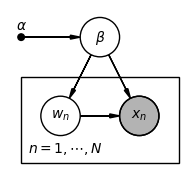

In [4]:
# Instantiate the PGM.
pgm = daft.PGM()

# Hierarchical parameters.
pgm.add_node("alpha", r"$\alpha$", 0.5, 2, fixed=True)
pgm.add_node("beta", r"$\beta$", 1.5, 2)

# Latent variable.
pgm.add_node("w", r"$w_n$", 1, 1)

# Data.
pgm.add_node("x", r"$x_n$", 2, 1, observed=True)

# Add in the edges.
pgm.add_edge("alpha", "beta")
pgm.add_edge("beta", "w")
pgm.add_edge("w", "x")
pgm.add_edge("beta", "x")

# And a plate.
pgm.add_plate([0.5, 0.5, 2, 1], label=r"$n = 1, \cdots, N$", shift=-0.1)

# Render
pgm.render()
plt.show()

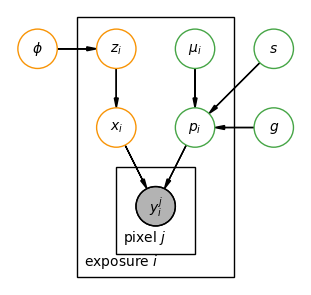

In [5]:
# Colors.
p_color = {"ec": "#46a546"}
s_color = {"ec": "#f89406"}

pgm = daft.PGM()

n = daft.Node("phi", r"$\phi$", 1, 3, plot_params=s_color)
n.va = "baseline"
pgm.add_node(n)
pgm.add_node("speckle_coeff", r"$z_i$", 2, 3, plot_params=s_color)
pgm.add_node("speckle_img", r"$x_i$", 2, 2, plot_params=s_color)

pgm.add_node("spec", r"$s$", 4, 3, plot_params=p_color)
pgm.add_node("shape", r"$g$", 4, 2, plot_params=p_color)
pgm.add_node("planet_pos", r"$\mu_i$", 3, 3, plot_params=p_color)
pgm.add_node("planet_img", r"$p_i$", 3, 2, plot_params=p_color)

pgm.add_node("pixels", r"$y_i ^j$", 2.5, 1, observed=True)

# Edges.
pgm.add_edge("phi", "speckle_coeff")
pgm.add_edge("speckle_coeff", "speckle_img")
pgm.add_edge("speckle_img", "pixels")

pgm.add_edge("spec", "planet_img")
pgm.add_edge("shape", "planet_img")
pgm.add_edge("planet_pos", "planet_img")
pgm.add_edge("planet_img", "pixels")

# And a plate.
pgm.add_plate([1.5, 0.2, 2, 3.2], label=r"exposure $i$", shift=-0.1)
pgm.add_plate([2, 0.5, 1, 1], label=r"pixel $j$", shift=-0.1)

# Render and save.
pgm.render()
plt.show()

### Problem 1: Inferring the tangential velocity and distance of a star

Let's start with a problem that is always on my mind in this era of Gaia: We are given the parallax of a star and we want to infer its distance. To do this, we will construct a probabilistic model that generates the observed data given some parameters (i.e. a "generative model"). In this case, the generative model is simple: the uncertainties that Gaia reports are Gaussian, so we assume that the observed parallax $\varpi$ of a star is generated with distance $r$ as:

$$
\varpi = 1 / r + \textrm{noise}
$$

In this model, we have just one unobserved random variable: the distance $r$ that we would like to infer. A PGM for this model would look like:

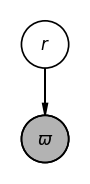

In [6]:
pgm = daft.PGM(dpi=120)

pgm.add_node("plx", r"$\varpi$", 0, 0, observed=True)
pgm.add_node("r", "$r$", 0, 1)

pgm.add_edge("r", "plx")

pgm.render();

The joint probability distribution function for this model is
$$
p(r, \varpi)
$$

The graph tells us that one way to factorize this joint distribution is as

$$
p(r, \varpi) = p(\varpi | r) \, p(r)
$$

This is a valid PGM, but I want to introduce one other convention that you may sometimes encounter (and is useful to build up to hierarchical models later). What is $p(r)$ in the factorization above? This is a prior probability distribution over the distance $r$! In the model above, we haven't actually specified what this prior distribution is. In this particular example (distance inference from a parallax), a common choice might be to assume an [*exponentially decreasing volume density prior*](https://arxiv.org/abs/1507.02105) that looks like

$$
p(r) = \frac{1}{2\,L^3} \, \frac{r^2}{e^{r/L}}
$$

This prior pdf has its own parameter $L$ that we have to fix before we go about our inference here. As a way of indicating this in a PGM, you may sometimes see fixed prior parameters appear as their own vertices in a PGM:

**Finally, a question:** We are given the observed parallax $\varpi$ and total proper motion $\mu$ (i.e. the scalar $\mu = \sqrt{\mu_\alpha^2 + \mu_\delta^2} = v_{\textrm{tan}} / r$). Use the `daft` package as above, or a sheet of paper, or a whiteboard to draw a graphical model for a model in which we would like to infer the tangential velocity $v_\textrm{tan}$ *and* the distance $r$ given the observed total proper motion $\mu$ and parallax $\varpi$. Assume that the prior for $v_\textrm{tan}$ depends on a single parameter $\theta$.

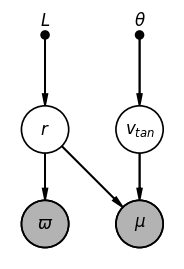

In [14]:
pgm = daft.PGM(dpi=120)

pgm.add_node("plx", r"$\varpi$", 0, 0, observed=True)
pgm.add_node("r", "$r$", 0, 1)
pgm.add_node("L", "$L$", 0, 2, fixed=True)
pgm.add_node("theta", r"$\theta$", 1, 2, fixed=True)
pgm.add_node("vtan", "$v_{tan}$", 1, 1)
pgm.add_node("mu", r"$\mu$", 1, 0, observed=True)

pgm.add_edge("r", "plx")
pgm.add_edge("L", "r")

pgm.add_edge("r", "mu")
pgm.add_edge("theta", "vtan")
pgm.add_edge("vtan", "mu")

pgm.render();

### Problem 2: Inferring the distance to a cepheid using a period–luminosity relation

We are given the observed period $P$ and mean flux $\langle f \rangle$ of a pulsating variable star, e.g., a Cepheid. We know that Cepheids obey a period–luminosity relation, so that the mean luminosity $\mathcal{L}$ of a Cepheid can be predicted once its period is known following the relation:

$$
\mathcal{L} = a\,P + b
$$

where $a$ and $b$ are known values that have been previously calibrated and, here, fixed. We want to infer the distance and luminosity of a Cepheid given its period $P$ and (bolometric) mean flux $\langle f \rangle$.

Note also that

$$
\mathcal{\langle f \rangle} = \frac{\mathcal{L}}{4\pi \, r^2}
$$

Use the `daft` package as above, or a sheet of paper, or a whiteboard to draw a graphical model for this model.

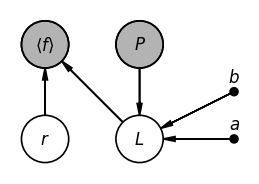

In [15]:
pgm = daft.PGM(dpi=120)

pgm.add_node("r", "$r$", 0, 0)
pgm.add_node("f", r"$\langle f \rangle$", 0, 1, observed=True)
pgm.add_node("L", r"$L$", 1, 0)
pgm.add_node("P", r"$P$", 1, 1, observed=True)
pgm.add_node("a", r"$a$", 2, 0, fixed=True)
pgm.add_node("b", r"$b$", 2, 0.5, fixed=True)

pgm.add_edge("r", "f")
pgm.add_edge("L", "f")
pgm.add_edge("P", "L")
pgm.add_edge("a", "L")
pgm.add_edge("b", "L")

pgm.render();

### Problem 3: Fitting a sinusoid to data

As another example, we'll move on to another problem motivated by variable star observations: Our goal is to infer the period, amplitude, and mean flux for a star that is observed to display periodic, sinusoidal variability.

We will assume that the times of observation (i.e. the times at which we have flux measurements) are known precisely enough such that we can ignore measurement uncertainty on the times, but the fluxes have Gaussian uncertainties due to the faintness of the star. Our observed data are then the times $t_n$ (where the subscript $n$ refers to the index of the observation number), the set of fluxes $f_n$, and the flux uncertainties $\sigma_n$, and we will assume we have $N=64$ observations.

Under the assumption that the flux variability is sinusoidal with a mean flux $f_0$, our physical model for the flux $f$ as a function of time $t$ given amplitudes $a,b$ and period $P$ might look like:

$$
f(t) = f_0 + a\,\cos\left(\frac{2\pi \, t}{P}\right) + b\,\sin\left(\frac{2\pi \, t}{P}\right)
$$

In this case, we have 4 random variables $f_0, a, b, P$ — i.e. the parameters of our physical model — the data are measured fluxes $f_n$, and we are given perfectly-known metadata for each flux observation in the times $t_n$ and flux uncertainties $\sigma_n$. A PGM for this model (without specifying fixed parameters of the prior pdfs) is shown below:

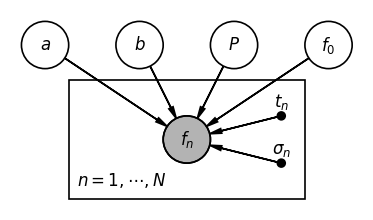

In [16]:
pgm = daft.PGM(dpi=120)

pgm.add_node("a", "$a$", 0, 1)
pgm.add_node("b", "$b$", 1, 1)
pgm.add_node("P", "$P$", 2, 1)
pgm.add_node("f_0", "$f_0$", 3, 1)

pgm.add_node("f_n", "$f_n$", 1.5, 0, observed=True)
pgm.add_node("t_n", "$t_n$", 2.5, 0.25, fixed=True)
pgm.add_node("sigma_n", r"$\sigma_n$", 2.5, -0.25, fixed=True)

pgm.add_edge("a", "f_n")
pgm.add_edge("b", "f_n")
pgm.add_edge("P", "f_n")
pgm.add_edge("f_0", "f_n")
pgm.add_edge("t_n", "f_n")
pgm.add_edge("sigma_n", "f_n")

pgm.add_plate([0.25, -0.5, 2.5, 1.125], label=r"$n = 1, \cdots, N$", shift=-0.125)

pgm.render();

Reading the graph, if we want to generate an observed flux $f_n$, we need values for the four parameters $f_0, a, b, P$, a measurement time $t_n$, and an uncertainty $\sigma_n$.

We can see what this means for factorization of the joint pdf — let's start by writing down the joint pdf for this model:

$$
p(a, b, P, f_0, \{f_n\}_N)
$$

(where $\{f_n\}_N$ represents the set of all $N$ flux measurements). Explain why

$$
p(a, b, P, f_0, \{f_n\}_N) = p(a) \, p(b) \, p(P) \, p(f_0) \, \prod_n^N p(f_n | a, b, P, f_0).
$$

### Problem 4: Fitting a straight line to data

We now have all of the tools we need to write down a graphical model for a classic problem: fitting a straight line to data. In this problem, we observe data $y$ with uncertainty $\sigma_y$ as a function of some other quantity $x$ that we assume has negligible uncertainty. We would like to infer the slope $m$ and intercept $b$ of a linear model given the data such that our parametric, generative model for the true $y$ values is:

$$
y = m\,x + b
$$

For this parametric model, and assuming Gaussian uncertainties, the likelihood is:

$$
p(y \,|\, m, b) = N(y \,|\, m\,x + b, \sigma_y^2)
$$

where $N(x \,|\, \mu, \sigma^2)$ represents a univariate normal distribution with mean $\mu$ and variance $\sigma^2$ (i.e. $\sigma$ is the standard deviation), i.e.

$$
N(x \,|\, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi} \, \sigma} \,
    \exp\left[-\frac{(x - \mu)^2}{2\,\sigma^2} \right]
$$

The posterior pdf is:

$$
p(m, b \,|\, \{y\}_N)
    \propto \left[\prod_n^N N(y_n \,|\, m\,x_n + b, \sigma_{y, n}^2) \right] \, p(m) \, p(b)
$$

Use the daft package, or a sheet of paper, or a whiteboard to draw a graphical model for this model.

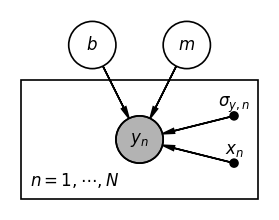

In [20]:
pgm = daft.PGM(dpi=120)

pgm.add_node("yn", r"$y_n$", 1.5, 0, observed=True)
pgm.add_node("b", r"$b$", 1, 1)
pgm.add_node("m", r"$m$", 2, 1)
pgm.add_node("xn", r"$x_n$", 2.5, -0.25, fixed=True)
pgm.add_node("sigmayn", r"$\sigma_{y, n}$", 2.5, 0.25, fixed=True)

pgm.add_edge("b", "yn")
pgm.add_edge("m", "yn")
pgm.add_edge("xn", "yn")
pgm.add_edge("sigmayn", "yn")

pgm.add_plate([0.25, -0.5, 2.5, 1.125], label=r"$n = 1, \cdots, N$", shift=-0.125)
pgm.render();

### Problem 5: Inferring the radial velocity of a star from an Echelle spectrum

We are given an [Echelle spectrum](https://en.wikipedia.org/wiki/Echelle_grating) for a star and would like to measure the radial velocity of the star. The details aren't critical for this example, but briefly, an Echelle spectrograph splits different sections of a spectrum (in wavelength) into different chunks that land on different parts of the detector, leading to a 2D dispersed spectrum. For example, the below shows a high resolution spectrum of the Sun where each row is a different spectral order:

![Image](https://storage.noirlab.edu/media/archives/images/screen/noao-sun.jpg "echelle spectrum of the Sun")

Our goal now is to write down a graphical model for this inference problem.

The spectrum is split into $K$ different spectral orders, indexed by $k$. Assume we have extracted the 2D spectrum into $K$ 1D spectra that give us the flux $f_k$ as a function of wavelength $\lambda_k$ for each spectral order $k$, evaluated on an (oversampled) pixel grid set by the detector. The full arrays of flux and wavelength are $f$ and $\lambda$.

To determine the radial velocity, we will fit for the centroid and widths of all spectral lines assuming they are Gaussian, and the local slope of the spectrum (assuming that the continuum of the spectrum is linear within each order). *Note: these are not great assumptions for working with real data!* Once we get the observed line locations, we can then compare to laboratory values to obtain the radial velocity (i.e. the RV won't appear in this model explicitly).

Over the whole spectrum, there are $M$ spectral lines, indexed by $m$, and each spectral line has a centroid or mean location in wavelength $\mu_m$ and a standard deviation $\sigma_m$. The continuum flux in each spectral order $k$ has a slope $a_k$ and an offset $b_k$.

Use the `daft` package as above, or a sheet of paper, or a whiteboard to draw a graphical model for this model. For tihs problem, there are multiple ways of constructing this PGM, so keep an open mind if you and your group members have different ideas!